<h1>CS166: Traffic Simulation Assignment</h1>
<h2>Part 1: Traffic Jams on a Circular Road</h2>
<h3>Nagel-Schreckenberg Model</h3>

Single-lane, Variable speed, Traffic Model

In [597]:
#import libraries
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
sns.set()
%matplotlib inline

In [608]:
class TrafficSim:

    def __init__(self, length=100, no_of_lanes=1, car_density=0.3, slow_down_prob=0.5, max_speed=5, demo = False):
        '''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Inputs:

            length (int) The number of cells in the lane. 
                Default: 100.
            
            no_of_lanes (int) The number of lanes in the simulation. 
                Default: 1.

            car_density (float) The fraction of cells that have a car on them.
                Default: 0.3.

            slow_down_prob (float) The probability that a car will randomly
                slow down by 1 during an update step. 
                Default: 0.5.

            max_speed (int) The maximum speed in car cells per update step.
                Default: 5.
              
            demo (bool) If True, will display the lane along with all the cars on it.
                Default: False
        '''
        self.demo = demo
        self.length = length
        self.car_density = car_density
        self.no_of_lanes = no_of_lanes
        self.max_speed = max_speed
        self.slow_down_prob = slow_down_prob

        # Track the time steps and total number of cars that passed the simulation
        # boundary to estimate average traffic flow.
        self.time_step = 0
        self.cumulative_traffic_flow = 0
        
        #set state by creating the lane(s)
        self.state = self.create_lane()
            
    
    def create_lane(self):
        '''
        Initializes lane according to road length, car density, and number of lanes.
        '''
            
        #choose random indexes to place the cars
        random_indexes = np.random.choice(range(self.length*self.no_of_lanes),                   
                                                size=int(round(self.car_density * self.length * self.no_of_lanes)),                
                                                replace=False)
        
        # -1 means empty cell
        state = -np.ones(self.length*self.no_of_lanes, dtype=int)  
        
        #place cars with random velocities along the lane
        state[random_indexes] = np.random.randint(0, self.max_speed + 1, 
                                                      size=len(random_indexes))
    
        return np.split(state, self.no_of_lanes) 
    
        
    def get_distances(self, curr_lane, index):
        '''
        Get the front and back distances of the given car.
        Distance is the number of empty cells between current car and next car plus 1.
        
        Inputs: 
        
            curr_lane: The current road that the car is on (numpy array)
            index: The index of the current car.
            
        Outputs: 
            
            front_dist: The available front distance of the current car.
            back_dist: The available back distance of the current car.
            
        '''
        
        front_dist, back_dist = 1,1

        while curr_lane[(index + front_dist) % len(curr_lane)] == -1:
            front_dist += 1
            if front_dist >= 6: break
        while curr_lane[(index - back_dist) % len(curr_lane)] == -1:
            back_dist += 1
            if back_dist >= 6: break
                
        return front_dist, back_dist  
    
    def update_cars(self):
        '''
        Update car velocities.
        
        For single-lane model, the following checks are implemented:
        
        - acceleration:
        All cars not at the maximum velocity have their velocity increased by one unit.
        
        - deceleration:
        If the front distance is smaller than the velocity, the velocity is reduced to (distance-1). 
        
        - randomization:
        Cars that have a velocity >= 1 have their speed reduced by one unit with a probability of p.
        '''
        for i in range(self.length):
            #if the index is a car
            if self.state[0][i] != -1: 
                
                #get the front and back distances of the current car
                f_dist, b_dist = self.get_distances(self.state[0],i)
                
                #Acceleration
                if self.state[0][i] + 1 < f_dist:
                    self.state[0][i] = min(self.state[0][i] + 1, self.max_speed)
                
                #Deceleration
                else: self.state[0][i] = max(f_dist - 1, 0)
                
                #Randomization
                if (self.state[0][i] > 0) and (np.random.uniform() < self.slow_down_prob):
                    self.state[0][i] -= 1
        
    def move_cars(self):
        
        '''
        Move cars according to their updated velocities.
        '''
        
        # initialize new empty state according to length and number of lanes
        new_state = np.split(-np.ones(self.length*self.no_of_lanes, dtype=int), self.no_of_lanes)
        
        #loop through updated velocities from the old lane
        #and move cars to new positions in the new lane
        for lane in range(self.no_of_lanes):
            for i in range(self.length):
                if self.state[lane][i] != -1:
                    new_state[lane][(i + self.state[lane][i]) % self.length] = self.state[lane][i]
                    
        return new_state  

    def step(self):
        '''
        Advance one time step in the simulation.
        '''
        #update car velocities
        self.update_cars()

        #if demo == True, display the traffic sim
        if self.demo: self.display()

        #Move cars 
        self.state = self.move_cars()

        #Update time and traffic flow
        self.get_traffic_flow()

    def get_traffic_flow(self):
        '''
        Traffic flow is calculated as the number of cars that pass the periodic boundary per time step.
        This function updates the time step by 1, and updates the number of cars that have passed 
        the periodic boundary at a given time step.
        '''
        self.time_step += 1
        for lane in range(len(self.state)):
            for i in range(self.max_speed):
                if self.state[lane][i] > i:
                    self.cumulative_traffic_flow += 1
                    
    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        for lane in range(self.no_of_lanes):
            print(''.join('.' if x == -1 else str(x) for x in self.state[lane]))
            #print(sum([1 if x == -1 else 0 for x in self.state[lane]]))
        print()
        

In [609]:
np.random.seed(20)

sim = TrafficSim(car_density=0.4,demo=True)

print("Implementing state updates")
for i in range(10):
    sim.step()
    
    

Implementing state updates
000.01..2...2......0.0.3...3...2...00003....0.0000.1....3...1..002...01.0.0.02.........001..02..2...

001.1.1...3...2....1.1....2...1..0.0001...1.0.0001..1......1.0.01..1.0.01.1.1..2.......01.1.1..1..0.

01.1.0.1.....2..2...0.1.....2..0.1.000.2...00.000.2..2......00.0.1..01.1.0.1.2...2.....0.1.1.2..0.1.

0.1.01..2......2..0.1..1......01..0001...1.01.000...2..3....00.0..1.0.0.00..1..3...3...0..0.1..00..0

0..01.2...2......00..1..1.....0.1.000.1...01.0000.....2...0.01.0...00.0.01...2....2...00..1..0.01..0

1..1.1..2...3....01...2..2....1..0000..1..1.00000.......0.1.1.00...00.1.0.1....3....0.00...1.1.0.0.0

.2..1.2...3....1.1.2....2..3...0.0001...1..000001.......1..0.001...00..00..2......1.1.00....1.01.1.1

1..0.1..3....1..1.2..3....3...00.001.1...0.00001.2.......1.0.01.2..00..00....3.....1.000.....01.0.0.

.0.0..2....2..1..2..2...3....001.00.1.2..1.0001.2..3......01.0.2..001..01.......2...0001.....1.01.0.

.0.1....3....1.2...2..3....1.01.001..1..1.0000.1..2...2

In [624]:
density=np.arange(0,1.05,0.05)

def sim_diff_density(traffic_sim, density=density, n_loops=100, **kwargs):
    
    '''
    Run traffic simulation at different densities to analyze traffic behavior.
    For each loop in n_loops, the simulation is updated by 100 steps.
    
    Inputs:
        
    traffic_sim (obj) The traffic simulation object.
                
    density (arr) The different levels of traffic density to test for.
        Default: np.arange(0,1.05,0.05)

    n_loops (int) The number of times to run the simulation.
        Default: 100
        
    Outputs:
    
    avg_traffic_flows (lst) Traffic flows for each density (count: n_loops)
    
    mean_traffic_flows (lst) Mean traffic flows for each density 
    
    CI_traffic_flows (lst) 95% Confidence intervals of traffic flows for each density 
    
    '''
    avg_traffic_flows = []
    mean_traffic_flows = []
    CI_traffic_flows = []

    for i in density:

        temp = []

        
        for t in range(n_loops):
            #initialize the sim with a given density
            sim = traffic_sim(car_density=i, **kwargs)
            
            #update the sim 100 times
            for j in range(100):
                sim.step()

            #get the traffic flow for a given density
            avg_traffic_flows.append((i, sim.cumulative_traffic_flow / sim.time_step))
            temp.append(sim.cumulative_traffic_flow / sim.time_step)

        #mean traffic flow for a given density
        mean_traffic_flows.append(np.mean(temp))
        
        #95 CI of traffic flow for a given density
        CI_traffic_flows.append(np.percentile(temp,[2.5,97.5]))
        
    return avg_traffic_flows, mean_traffic_flows, CI_traffic_flows
    
def plot_flow(avg_traffic_flows, mean_traffic_flows, CI_traffic_flows, title='', density=density):
    '''
    Plots the traffic flows, mean and 95% CI across different densities.
    x-axis: range of densities
    y-axis: traffic flow value
        
    Inputs:
    
    avg_traffic_flows (lst) Traffic flows for each density
    
    mean_traffic_flows (lst) Mean traffic flows for each density 
    
    CI_traffic_flows (lst) 95% Confidence intervals of traffic flows for each density 
    
    density (arr) The different levels of traffic density.
        Default: np.arange(0,1.05,0.05)
    
    '''
    traffic_flows = np.array(avg_traffic_flows)
    plt.figure(figsize=(10,6))
    
    plt.scatter(traffic_flows[:,0],traffic_flows[:,1], alpha = 0.5, c="orange")
    plt.plot(density, mean_traffic_flows)
    plt.plot(density, np.array(CI_traffic_flows)[:,0], ls='dashed')
    plt.plot(density, np.array(CI_traffic_flows)[:,1], ls='dashed')
    
    plt.title(f"Plot of Traffic Density vs Traffic Flow ({title})",size=15)
    plt.xlabel("Traffic Density",size=15)
    plt.ylabel("Traffic flow",size=15)
    plt.show()
    
def plot_df(mean_traffic_flows, CI_traffic_flows, density=density):
    '''
    Creates dataframe of the mean traffic flows and 95% CI across different densities.
        
    Inputs:
    
    mean_traffic_flows (lst) Mean traffic flows for each density 
    
    CI_traffic_flows (lst) 95% Confidence intervals of traffic flows for each density 
    
    density (arr) The different levels of traffic density.
        Default: np.arange(0,1.05,0.05)
    
    '''
    df = pd.DataFrame({
    'Traffic Density':density[::2],
    'Mean flow':mean_traffic_flows[::2],
    '95 CI':CI_traffic_flows[::2]
    })
    return df

In [626]:
single_lane_traffic_flows, single_lane_mean, single_lane_CI = sim_diff_density(TrafficSim) 


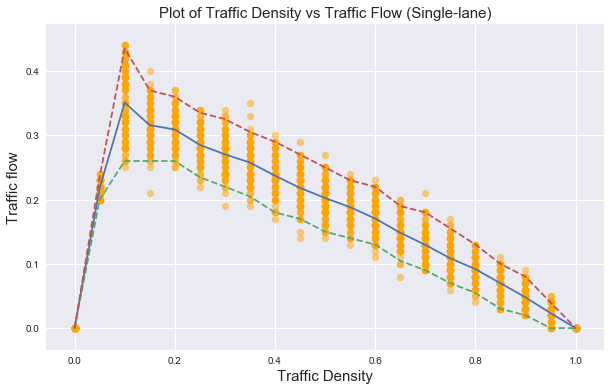

,Traffic Density,Mean flow,95 CI
0,0.0,0.0000,"[0.0, 0.0]"
1,0.1,0.3508,"[0.26, 0.4352499999999999]"
2,0.2,0.3091,"[0.26, 0.36]"
3,0.3,0.2704,"[0.22, 0.32524999999999993]"
4,0.4,0.2372,"[0.18, 0.29]"
5,0.5,0.2025,"[0.15, 0.25]"
6,0.6,0.1705,"[0.13, 0.22]"
7,0.7,0.1295,"[0.09, 0.18]"
8,0.8,0.0918,"[0.05475, 0.13]"
9,0.9,0.0479,"[0.02, 0.08]"


In [627]:
single_lane_plot = plot_flow(single_lane_traffic_flows, single_lane_mean, single_lane_CI, 'Single-lane')
single_lane_df = plot_df(single_lane_mean, single_lane_CI)
single_lane_df

<h2>Part 2: Multi-lane Highways</h2>
<h3>Two-lane Traffic Simulation Model</h3>

Two-lane, symmetric, uni-directional, variable speed model.

In [614]:
class TrafficSimTwoLane(TrafficSim):

    def __init__(self, length=100, no_of_lanes = 2, car_density=0.3, slow_down_prob=0.5, switch_lane_prob=1, max_speed=5, demo = False):
        
        '''
        TrafficSimTwoLane inherits from the TrafficSim parent class.
        The no_of_lanes is now defaulted at 2.
        A new variable, switch_lane_prob, is introduced.

        Inputs:
        
            no_of_lanes (int) The number of lanes in the simulation. 
                Default: 2.
                
            switch_lane_prob (int) The probability of a car switching lanes, 
                                    given that a lane switch is possible. 
                Default: 1.

        '''
        
        #inherit from parent TrafficSim class
        super().__init__(length, no_of_lanes, car_density, slow_down_prob, max_speed, demo)
        
        #initialize new variable, switch-lane_prob
        self.switch_lane_prob = switch_lane_prob
    
    def update_cars(self,old_state,curr_lane_index,other_lane_index):
        '''
        Update car velocities with/without lane switch.
        
        For two-lane model, the following checks are implemented:
        
        - acceleration:
        All cars not at the maximum velocity have their velocity increased by one unit.
        
        - lane switch:
        If car cannot accelerate in current lane, and there is sufficient front and back distance
        in the other lane, the car will switch to the other lane with probability = switch_lane_prob
        
        - deceleration:
        If the car cannot accelerate or switch lanes, the car decelerates. 
        The velocity is reduced to (distance-1).
        
        - randomization:
        Cars that have a velocity >= 1 have their speed reduced by one unit with a probability of p.
        
        Inputs:
        
            old_state (arr) A deep copy of the last updated state as reference when
                                    updating both lanes
                
            curr_lane_index (int) The index of the current lane that the car is on.
                                    
            other_lane_index (int) The index of the other lane that the car can switch to.
        '''

        for i in range(self.length):
            #if the index is a car
            if old_state[curr_lane_index][i] != -1: 
                
                #get front and back distance of current lane
                f_dist, b_dist = self.get_distances(old_state[curr_lane_index], i)
                
                #get front and back distance of other lane
                fo_dist, bo_dist = self.get_distances(old_state[other_lane_index], i)
                    
                #Acceleration in current lane
                if old_state[curr_lane_index][i] + 1 < f_dist:
                    self.state[curr_lane_index][i] = min(old_state[curr_lane_index][i] + 1, self.max_speed)
                
                else: #if acceleration is not possible:

                    #if switching lanes is possible, switch lane with probability switch_lane_prob.
                    if old_state[other_lane_index][i]==-1 and old_state[curr_lane_index][i] + 1 < fo_dist and bo_dist > self.max_speed:
                        if np.random.uniform() < self.switch_lane_prob:
                            self.state[other_lane_index][i] = min(old_state[curr_lane_index][i] + 1, self.max_speed)
                            self.state[curr_lane_index][i] = -1

                    #if switching lanes is not possible, decelerate in current lane
                    else: 
                        self.state[curr_lane_index][i] = max(f_dist - 1, 0)
                        #print(f'decel occured at index {i}')

                # Random slow down
                if (self.state[curr_lane_index][i] > 0) and (np.random.uniform() < self.slow_down_prob): 
                    self.state[curr_lane_index][i] -= 1
                    #print(f'Random slow down occured at index {i}')

        
    def step(self):
        '''
        Advance one time step in the simulation.
        '''
        #create deep copy of current state for reference when updating both lanes
        old_state = copy.deepcopy(self.state) 
        
        #update car velocities / switch lanes and update velocities
        self.update_cars(old_state,0,1)
        self.update_cars(old_state,1,0)

        #if demo == True, display the traffic sim
        if self.demo: self.display()

        #move cars
        self.state = self.move_cars()

        #Update time and traffic flow
        self.get_traffic_flow()

        
        

In [615]:
np.random.seed(2000)

sim = TrafficSimTwoLane(no_of_lanes=2, car_density=0.5, demo=True)

print("Implementing state updates")
for i in range(10):
    sim.step()
    

Implementing state updates
1.02..3....1.3...005.....000.002..0...1...2....0.004....01.002..00000.1..0.001..0.0.0.001.0...02..00
....0.1.1.0000002..0003...0001...0.000001..0.00...3...02..00.1.03......000002..002..01.3....00....02

.01..3...2..1...001.....0000.01..01....2....1..0.01....00.001..000001..0.0.01.1.0.0.0.01.00...1..001
.1..0..1.0000001..0001...0000.2..1.00001.1.0.01......01..000..01...2...00000..000..01.1...1.00....0.

00.1....1..0.1..00.2....0000.0.1.1.2.....3...0.1.1.1...00.01.0.00000.0.1.1.1.0.01.0.1.1.001....0.00.
..0.1...0000000.1.000.1..0001...0.00001.0.00.1.2.....1.1.000..1.1....1.00001..000..1.1.2...000....0.

00..2....1.1..0.00...2..0000.1..1.1..3......00..1.0.2..01.1.00.00000.1..0.1.01.0.00..0.000.2...1.00.
..1..2..0000001..0000..1.000.1..0.0000.01.00..1..2....1.0001...1.2....00000.1.001...0.2..1.000....0.

01....2...1.0.1.01.....00001..1..0.1....3...01...01...00.0.000.00000..0.1..01.01.00..0.000...2..000.
...1...0000000.1.0001...0001..1.0.0000.0.000...1...2...0000.

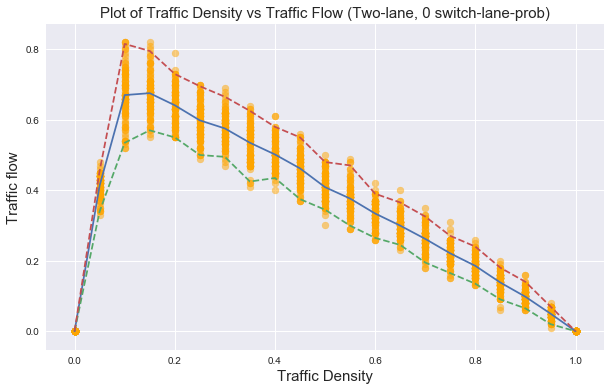

    Traffic Density  Mean flow                                     95 CI
0               0.0     0.0000                                [0.0, 0.0]
1               0.1     0.6701  [0.5347500000000001, 0.8152499999999999]
2               0.2     0.6411                              [0.55, 0.73]
3               0.3     0.5754             [0.49475, 0.6652499999999999]
4               0.4     0.5015               [0.43474999999999997, 0.58]
5               0.5     0.4087                           [0.34475, 0.48]
6               0.6     0.3339               [0.26475000000000004, 0.39]
7               0.7     0.2619            [0.19475, 0.32524999999999993]
8               0.8     0.1853                           [0.13475, 0.24]
9               0.9     0.0977                           [0.06475, 0.14]
10              1.0     0.0000                                [0.0, 0.0]


In [630]:
two_lane_traffic_flows, two_lane_mean, two_lane_CI = sim_diff_density(TrafficSimTwoLane, switch_lane_prob=0)
plot_flow(two_lane_traffic_flows, two_lane_mean, two_lane_CI, f'Two-lane, 0 switch-lane-prob')
print(plot_df(two_lane_mean, two_lane_CI))

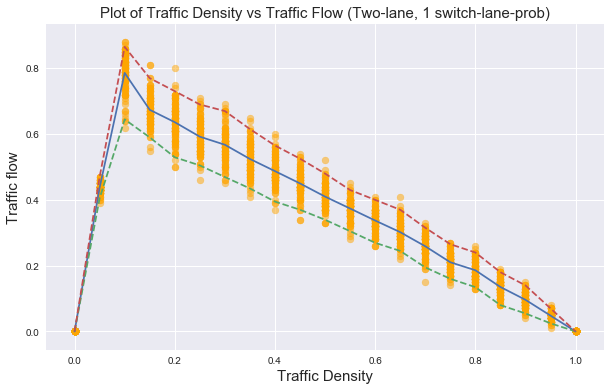

    Traffic Density  Mean flow                                      95 CI
0               0.0     0.0000                                 [0.0, 0.0]
1               0.1     0.7860              [0.64475, 0.8652499999999999]
2               0.2     0.6362   [0.5295000000000001, 0.7304999999999998]
3               0.3     0.5676                [0.46950000000000003, 0.67]
4               0.4     0.4874  [0.39475000000000005, 0.5652499999999999]
5               0.5     0.4099                             [0.3395, 0.48]
6               0.6     0.3372                              [0.2695, 0.4]
7               0.7     0.2589              [0.19475, 0.3152499999999999]
8               0.8     0.1860                            [0.13475, 0.24]
9               0.9     0.0962                            [0.05475, 0.14]
10              1.0     0.0000                                 [0.0, 0.0]


In [628]:
two_lane_traffic_flows, two_lane_mean, two_lane_CI = sim_diff_density(TrafficSimTwoLane, switch_lane_prob=1)
plot_flow(two_lane_traffic_flows, two_lane_mean, two_lane_CI, f'Two-lane, 1 switch-lane-prob')
print(plot_df(two_lane_mean, two_lane_CI))


In [685]:
class TrafficSimExtended(TrafficSim):
    
    def __init__(self, length=100, no_of_lanes = 1, car_density=0.3, slow_down_prob=0.5, 
                 max_speed=5, speed_lim=[5,1,5], 
                 speed_lim_zone=(0,[np.arange(0,34),np.arange(34,67),np.arange(67,100)]), 
                 traffic_light = (0,50,10,10),
                 obstacle = (0,30),
                 demo = False):
        
        '''
        TrafficSimExtended inherits from the TrafficSim parent class.
        New variables: speed_lim, speed_lim_zone.
        Inputs:
                
            speed_lim (arr) The speed limits in the speed limit zone ranges.
                Default: [5,2,5]
                
            speed_lim_zone (tuple) The speed limit zone lane and ranges.
                Default: (0,[np.arange(0,34),np.arange(34,67),np.arange(67,100)])
                
            traffic_light (arr) The traffic light lane, index, on-time, and off-time as a tuple.
                Default: (0,50,10,10) traffic light at lane 0, index 50, with 10 on-time and 10 off-time.
                
            obstacle (tuple) The lane and index of the obstacle.
                Default: (0,30) - First lane, index 30.

        '''
        
        #inherit from parent TrafficSim class
        super().__init__(length, no_of_lanes, car_density, slow_down_prob, max_speed, demo)
        
        #speed limit variables
        self.speed_lim = speed_lim
        self.speed_lim_zone = speed_lim_zone
        
        #traffic light variables
        self.traffic_light = traffic_light
        self.traffic_light_int = np.array(
                                    [np.arange(i, i + traffic_light[2]) 
                                    if (i+traffic_light[2])<length else np.arange(i,length) 
                                    for i in np.arange(length)[::(traffic_light[2]+traffic_light[3])]]
                                    ).flatten()
        
        #obstacle variables
        self.obstacle = obstacle
       
    def update_cars(self):

        for i in range(self.length):
            
            #if the index is the obstacle index
            if i == self.obstacle[1]:
                self.state[self.obstacle[0]][i] = 0
            
            #if not obstacle, proceed as usual
            else: 
                #if the index is a car
                if self.state[0][i] != -1: 

                    #check if car is at traffic light and traffic light is on
                    if self.traffic_light and self.check_traffic_light(0,i):
                        curr_max_speed = 0
                    else:
                        #check speed limit and set current max speed accordingly
                        curr_max_speed = self.check_speed_limit(0,i)

                    #get the front and back distances of the current car
                    f_dist, b_dist = self.get_distances(self.state[0],i)

                    #Acceleration
                    if self.state[0][i] + 1 < f_dist:
                        self.state[0][i] = min(self.state[0][i] + 1, curr_max_speed)

                    #Deceleration
                    else: self.state[0][i] = min(max(f_dist - 1, 0), curr_max_speed)

                    #Randomization
                    if (self.state[0][i] > 0) and (np.random.uniform() < self.slow_down_prob):
                        self.state[0][i] -= 1
                    

    def check_speed_limit(self,lane,index):
        '''
        set the current max speed of the car according to speed limit zone restrictions
        '''
        if lane == self.speed_lim_zone[0]:
            for i in range(len(self.speed_lim_zone[1])):
                #check which speed limit zone the car is in
                if index in self.speed_lim_zone[1][i]:
                    #assign the appropriate speed limit for that zone
                    return self.speed_lim[i]
        return self.max_speed
    
    def check_traffic_light(self,lane,index):
        '''
        Checks if the car is at the traffic light, and if the traffic light is on.
        Traffic light starts on at the first time-step, then turns on and off in regular intervals
        according to the traffic_light_on and traffic_light_off inputs provided during initialization.
        '''
        
        if lane == self.traffic_light[0] and index == self.traffic_light[1] and self.time_step in self.traffic_light_int:
            return True
        
    def display(self):
        '''
        Traffic light index is red when off, green when on.
        Obstacle is blue.
        '''
        for lane in range(self.no_of_lanes):
            
            disp = ['.' if x == -1 else str(x) for x in self.state[lane]]
            
            if lane == self.obstacle[0]:
                disp[self.obstacle[1]] = f"\x1b[34m{disp[self.obstacle[1]]}\x1b[0m"
            
            if lane == self.traffic_light[0]:
                if self.time_step in self.traffic_light_int:
                    disp[self.traffic_light[1]] = f"\x1b[31m{disp[self.traffic_light[0]]}\x1b[0m"
                else:
                    disp[self.traffic_light[1]] = f"\x1b[32m{disp[self.traffic_light[0]]}\x1b[0m"
            
            print(''.join(x for x in disp))
            
        print()
            


In [686]:
np.random.seed(10)

sim_ext = TrafficSimExtended(car_density=0.4,traffic_light = (0,50,5,5),demo=True)

print("Implementing state updates")
for i in range(10):
    sim_ext.step()
    

Implementing state updates
.000002.......4....0.3....2...0...01.001.000000.0...01.1...001.0..0.1.0...1.1..0....2.....0.1..2....

.00001..2.........00....3...0.0...1.000.0000001.0...0.1.0..00.01..0..00....1.1.1......3...0..2...3..

00001.2...3.......01.......01.0....0000.000000.01.0.0..00..00.1.1.0..01.....1.1.1........00....2....

0000.1..2....4....1.1......0.00....0001.000001.1.00.1..01..01..1.00..1.1.....0.1.1.......01......1..

0000..2...3......0.0.1.....0.00....000.000001.0.000..0.1.0.1.1..000...0.2....1..0.2......0.1......1.

0001....3....3...0.1..2....0.00....001.00000.00.000..0..00..0.1.000...0...3...0.0...3....0..2......0

000.2......4....01..2...1..0.00....00.000001.01.000..0..01..0..0000...1......01.0......1.0....3....0

000...3........01.2...1..0.1.00....01.00001.00.0000..0..1.1.0..0000....2.....1.01.......01.......1.0

001......3.....0.1..2..0.1..000....0.00001.000.0000..1...0.00..0001......2....00.1......0.2.......00

00.2........2..1..2...01..0.000....0.0001.0000.00101..1

In [654]:
single_lane_ext_traffic_flows, single_lane_ext_mean, single_lane_ext_CI = sim_diff_density(TrafficSimExtended)



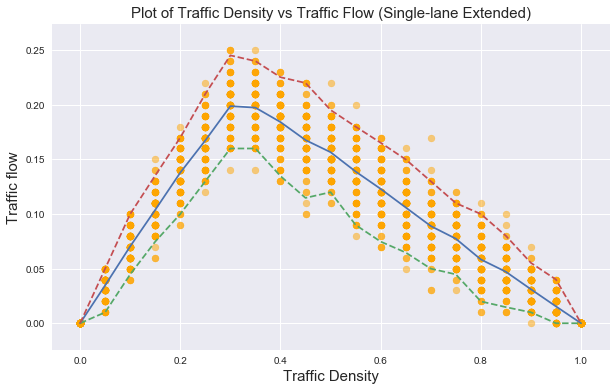

,Traffic Density,Mean flow,95 CI
0,0.0,0.0000,"[0.0, 0.0]"
1,0.1,0.0704,"[0.044750000000000005, 0.1]"
2,0.2,0.1379,"[0.1, 0.17]"
3,0.3,0.1988,"[0.16, 0.2452499999999999]"
4,0.4,0.1842,"[0.13475, 0.22524999999999992]"
5,0.5,0.1566,"[0.12, 0.19524999999999992]"
6,0.6,0.1230,"[0.07475000000000001, 0.16524999999999992]"
7,0.7,0.0890,"[0.05, 0.13]"
8,0.8,0.0584,"[0.02, 0.1]"
9,0.9,0.0311,"[0.01, 0.05524999999999991]"


In [655]:
plot_flow(single_lane_ext_traffic_flows, single_lane_ext_mean, single_lane_ext_CI, 'Single-lane Extended')
single_lane_ext_df = plot_df(single_lane_ext_mean, single_lane_ext_CI)
single_lane_ext_df


In [698]:
class TrafficSimExtendedTwoLane(TrafficSimExtended):
    
    def __init__(self, length=100, no_of_lanes = 2, car_density=0.3, 
                 slow_down_prob=0.5, switch_lane_prob = 1,
                 max_speed=5, speed_lim=[5,1,5], 
                 speed_lim_zone=(0,[np.arange(0,34),np.arange(34,67),np.arange(67,100)]), 
                 traffic_light = (0,50,10,10),
                 obstacle = (0,30),
                 lane_merge = (0,np.arange(75,100)),
                 demo = False):
        
        '''
        TrafficSimExtendedTwoLane inherits from the TrafficSimExtended parent class.
        The no_of_lanes is now defaulted at 2.
        A new variable, switch_lane_prob, is introduced.

        Inputs:
        
            no_of_lanes (int) The number of lanes in the simulation. 
                Default: 2.
                
            switch_lane_prob (int) The probability of a car switching lanes, 
                                    given that a lane switch is possible. 
                Default: 1.
                
            lane_merge (tuple) The lane and indices where lane-merge occurs.
                Default: (0,np.arange(74,100))

        '''
        
        #inherit from TrafficSimExtended class
        super().__init__(length, no_of_lanes, car_density, slow_down_prob, 
                         max_speed, speed_lim, speed_lim_zone, 
                         traffic_light, obstacle, demo)
        
        #initialize new variable, switch-lane_prob
        self.switch_lane_prob = switch_lane_prob
        
        #lane-merge variable
        self.lane_merge = lane_merge
       
    def update_cars(self,old_state,curr_lane_index,other_lane_index):

        for i in range(self.length):
            
            #obstacle check
            if curr_lane_index == self.obstacle[0] and i == self.obstacle[1]:
                self.state[curr_lane_index][i] = 0
                
            #lane-merge check
            if curr_lane_index == self.lane_merge[0] and i in self.lane_merge[1]:
                self.state[curr_lane_index][i] = 0
            
            #if not obstacle, proceed as usual
            else:
                #if the index is a car
                if old_state[curr_lane_index][i] != -1: 

                    #check if car is at traffic light and traffic light is on
                    if self.traffic_light and self.check_traffic_light(curr_lane_index,i):
                        curr_max_speed = 0

                    else: 
                        #check speed limit and set current max speed accordingly
                        curr_max_speed = self.check_speed_limit(curr_lane_index,i)

                    #get front and back distance of current lane
                    f_dist, b_dist = self.get_distances(old_state[curr_lane_index], i)

                    #get front and back distance of other lane
                    fo_dist, bo_dist = self.get_distances(old_state[other_lane_index], i)

                    #Acceleration in current lane
                    if old_state[curr_lane_index][i] + 1 < f_dist:
                        self.state[curr_lane_index][i] = min(old_state[curr_lane_index][i] + 1, curr_max_speed)

                    else: #if acceleration is not possible:

                        #if switching lanes is possible, switch lane with probability switch_lane_prob.
                        if old_state[other_lane_index][i]==-1 and old_state[curr_lane_index][i] + 1 < fo_dist and bo_dist > curr_max_speed:
                            if np.random.uniform() < self.switch_lane_prob:
                                self.state[other_lane_index][i] = min(old_state[curr_lane_index][i] + 1, curr_max_speed)
                                self.state[curr_lane_index][i] = -1

                        #if switching lanes is not possible, decelerate in current lane
                        else: 
                            self.state[curr_lane_index][i] = max(f_dist - 1, 0)
                            #print(f'decel occured at index {i}')

                    # Random slow down
                    if (self.state[curr_lane_index][i] > 0) and (np.random.uniform() < self.slow_down_prob): 
                        self.state[curr_lane_index][i] -= 1
                        #print(f'Random slow down occured at index {i}')

        
    def step(self):
        '''
        Advance one time step in the simulation.
        '''
        #create deep copy of current state for reference when updating both lanes
        old_state = copy.deepcopy(self.state) 
        
        #update car velocities / switch lanes and update velocities
        self.update_cars(old_state,0,1)
        self.update_cars(old_state,1,0)

        #if demo == True, display the traffic sim
        if self.demo: self.display()

        #move cars
        self.state = self.move_cars()

        #Update time and traffic flow
        self.get_traffic_flow()
        
    def display(self):
        '''
        Traffic light index is red when off, green when on.
        Obstacle is blue.
        Lane merge is represented as '_'
        '''
        for lane in range(self.no_of_lanes):
            
            disp = ['.' if x == -1 else str(x) for x in self.state[lane]]
            
            if lane == self.obstacle[0]:
                disp[self.obstacle[1]] = f"\x1b[34m{disp[self.obstacle[1]]}\x1b[0m"
                
            if lane == self.lane_merge[0]:
                for i in range(len(self.lane_merge[1])):
                    disp[self.lane_merge[1][i]] = '_'
            
            if lane == self.traffic_light[0]:
                if self.time_step in self.traffic_light_int:
                    disp[self.traffic_light[1]] = f"\x1b[31m{disp[self.traffic_light[0]]}\x1b[0m"
                else:
                    disp[self.traffic_light[1]] = f"\x1b[32m{disp[self.traffic_light[0]]}\x1b[0m"
            
            print(''.join(x for x in disp))
            
        print()

        

In [699]:
np.random.seed(20)

sim_ext = TrafficSimExtendedTwoLane(car_density=0.4,demo=True)

print("Implementing state updates")
for i in range(10):
    sim_ext.step()

Implementing state updates
01...1......04......01......000...00.4......0000..03...3...0..0.1..02...3.._________________________
....2..0.0.005.......01...0.001..01.1..2...2...1.01.00.1..1....1.0001.....00003....001.1...01..000.4

1.2...2.....1....1..0.2.....000...00.....2..0001..1...2...00..1..0.0..3...._________________________
...1..00.1.01.....1..0.2..1.01.1.1.1.2...3...2..00.001..1..2....0001.1....0001...0.00.1.2..1.0.001..

.2..3...3....1....0.0...3...000...01.......0001.1.......1.00...1.0.0.....1._________________________
....1.01..00.2.....1.0...0.01.1.0.1.1..2....1..000.01.2..1...2..000.0.2...000.2..1.01..2..1.01.01.1.

...3...3...2..1...1.1......0001...0.0.......01.1.1.......001....01.1......0_________________________
.....01.1.00...3....00...0.0.0.00..1.2...3.1.0.001.0.1..0.2....0000.1...1.000...0.00.2...1.01.00.0.1

......2...1..0.2...1.2.....00102..0.0.......1.1.1........00.0...1.0.1.....0_________________________
2....1.1.001......0.00...0.0.1.00...1..2....00.00.01..0.0...

In [678]:
two_lane_ext_traffic_flows, two_lane_ext_mean, two_lane_ext_CI = sim_diff_density(TrafficSimExtendedTwoLane)



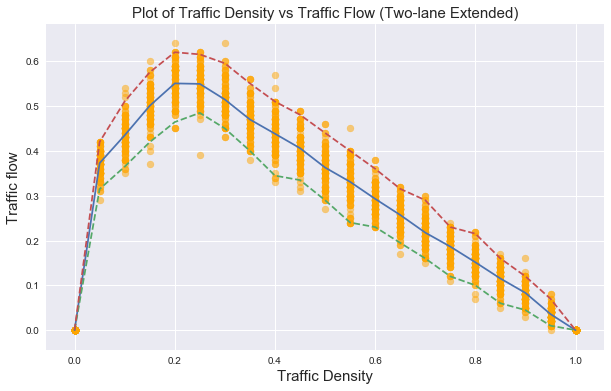

,Traffic Density,Mean flow,95 CI
0,0.0,0.0000,"[0.0, 0.0]"
1,0.1,0.4347,"[0.36475, 0.5104999999999998]"
2,0.2,0.5505,"[0.46425, 0.62]"
3,0.3,0.5145,"[0.45, 0.5952499999999998]"
4,0.4,0.4382,"[0.34475, 0.51]"
5,0.5,0.3628,"[0.29, 0.44]"
6,0.6,0.2929,"[0.23, 0.36]"
7,0.7,0.2176,"[0.16, 0.29]"
8,0.8,0.1514,"[0.1, 0.21524999999999989]"
9,0.9,0.0831,"[0.044750000000000005, 0.12]"


In [679]:
plot_flow(two_lane_ext_traffic_flows, two_lane_ext_mean, two_lane_ext_CI, 'Two-lane Extended')
two_lane_ext_df = plot_df(two_lane_ext_mean, two_lane_ext_CI)
two_lane_ext_df


<b>Normal part</b>

- check different densities and effect of different switch lane probs

<b>Hypotheses for stretch goal:</b>

<b>Single-lane hypotheses</b>

1) Examine effect of speed-limit zone on single lane

2) Examine effect of traffic-light on single lane

3) Examine effect of both on single-lane (traffic light in front of speed limit zone vs traffic light after speed limit zone)

4) Examine effect of obstacle

<b>Two-lane hypotheses</b>

- From the single-lane testing, check whether traffic-light before or after speed limit zone is better for flow. Use the better version in the dual lane testing for hypotheses 1 and 2

1) Examine effect of speed-limit zone on one-lane (emulating a slower and faster lane in real life)

2) Examine effect of speed-limit zones on both lanes (comparing the performance of two-lane speed-limit vs one-lane speed-limit)

3) Examine effect of obstacle on one-lane

4) Examine effect of lane-merge

5) Examine effect of speed-limit zone before lane merge

Potential HCs: 
- estimation (estimating the traffic flow on 3-lane or higher models)
- descriptivestats
- confidenceinterval (explaning the confidence intervals included in the traffic flow plot)
- systemdynamics (identify potential attractor states - what are the typical "stable states" of the models?)
- studyreplication (replicating nagel-schreckenberg and rickert et al.'s models + extending on them)